# Imports

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import io
from google.colab.patches import cv2_imshow

# Manual Mode Setup

## Homography Matrix

In [97]:
# simple transpose function
def T (x):
  return np.transpose(x)

In [98]:
def getAb (A): 

  # current form: Ah=0
  # assume h22 = 1

  b = -A[:,-1] # new b matrix with last column of A
  A = np.delete(A, -1, -1) # remove last column of A

  # current form: Ax=b 
  
  return A,b

In [99]:
def generate_A (p1, p2, n):
  
  a = __chunk_1(p1, n) # First nx3 part of the A matrix
  b = __chunk_2(p1, n) # Second nx3 part of the A matrix
  c = __chunk_3(p1, p2, n) # Third nx3 part of the A matrix

  A = T(np.concatenate((T(a),T(b)))) # Combine part 1 and part 2 
  A = T(np.concatenate((T(A),T(c)))) # Combine part(1,2) and part 3

  return A

def __chunk_1 (P, n):
  a=np.zeros((n*2, 2))  # create an array of zeros
  a[::2] = P # append points to every other row (nx2)

  a_0 = np.zeros((n*2, 1)) # create array of zeros
  a_0[::2] = np.ones((n, 1))  # append ones to every other row (nx1)

  a = T(np.concatenate((T(a), T(a_0)))) # resulting nx3

  return a

def __chunk_2 (P, n): # same as __chunk_1(..) but with an additional zero row on top
  b = np.zeros((n*2+1, 2)) 
  b[::2] = np.append([[0,0]], P, axis=0)
  b = np.delete(b, 1, 0)

  b_0 = np.zeros((n*2+1, 1)) 
  b_0[::2] = np.ones((n+1, 1)) 
  b_0 = np.delete(b_0, 0, 0) # remove extra zero row

  b = T(np.concatenate((T(b), T(b_0))))

  return b

def __chunk_3 (p1, p2, n):
  c = np.array([[0,0,0]]) # init

  for i in range(0, n):
    tmp_= np.array([
      [-p2[i][0] * p1[i][0], # -x'n * xn
       -p2[i][0] * p1[i][1], # -x'n * yn
       -p2[i][0]]            # -x'n
      ])
    tmp__ = np.array([
      [-p2[i][1] * p1[i][0], # -y'n * xn
       -p2[i][1] * p1[i][1], # -y'n * yn
       -p2[i][1]]            # -y'n
      ])
    c_ = np.append(tmp_, tmp__, axis=0) # append two halves
    c = np.append(c, c_, axis=0) # append combined halves to return matrix

  c = np.delete(c, 0, 0) # remove init

  return c

In [100]:
def Ab_to_H(A,b):
  H = np.matmul(
      np.linalg.inv((np.matmul(T(A), A))),
      np.matmul(T(A), b)
  ) # TODO

  H = np.append(H, [[1]]).reshape(3,3) # need a 1 in the bottom right corner!

  return H

In [101]:
# given two images, use the Ax=b thing
def computeH(im_src_pts, im_dest_pts):

  n = im_src_pts.shape[0] 

  A = generate_A(im_src_pts, im_dest_pts, n) # original A matrix

  A,b = getAb(A)

  H = Ab_to_H(A,b)

  return H

## Warp Image

In [102]:
def warpImage(im,H,limit_coordinates):

  # get copies so that the original is not manipulated
  __im = im.copy()
  __H = H.copy()

  # unravel the coordinates provided
  (__xmin, __xmax, __ymin, __ymax) = limit_coordinates

  # create evenly spaced arrays based on the image shape
  # i and j correlate to the x/y values respectively 
  __i = np.linspace(
      0, 
      __im.shape[0]-1, 
      __im.shape[0]
  ).astype(int)
  
  __j = np.linspace(
      0, 
      __im.shape[1]-1, 
      __im.shape[1]
  ).astype(int)
  
  # create a rectangular grid from the linspace 
  __yv, __xv = np.meshgrid(__i, __j)

  

  # combine all values into a 1d array and then get the shape
  __numpoints = __xv.ravel().shape[0]

  # get new xy coords
  __x_cord = __xv.ravel().reshape((1,__numpoints))
  __y_cord = __yv.ravel().reshape((1,__numpoints))

  # create new grid based on the new xy coords
  __grid = np.concatenate(
      (
          __x_cord, 
          __y_cord, 
          np.ones((1,__numpoints))
      ),
      axis=0
  )

  # now that the new grid is created we need to apply our 
  # homography matrix
  __newgrid = np.matmul(__H, __grid)

  # extract the heterogenous portion of the grid, since we can't use 
  # the homogenous portion it will need to be neutralized
  __newgridHetero = __newgrid[:2,:]

  # calculate w and then divide the heterogenous portion of the matrix
  # by that value to reduce it's form
  __w = __newgrid[2,:]
  __newgridHetero[0,:] /= __w
  __newgridHetero[1,:] /= __w

  # initialize the warped matrix with -1's
  __warped = -np.ones((__xmax,__ymax,3)).astype(np.int16)

  # create a new grid with the original Hetero matrix, but 
  # rounded to the nearest int (px)
  __newgrid2= __newgridHetero.round().astype(np.int64)

  # calculate local and apply
  __validsX= np.bitwise_and(
      __newgrid2[0,:]>=__xmin,
      __newgrid2[0,:]<__xmax
  )
  
  __validsY= np.bitwise_and(
      __newgrid2[1,:]>=__ymin,
      __newgrid2[1,:]<__ymax
  )
  
  __valids = np.bitwise_and(
      __validsX,
      __validsY
  )

  # get the respective rgb values for later use
  __r = __im[__yv.ravel(),__xv.ravel(),0]
  __g = __im[__yv.ravel(),__xv.ravel(),1]
  __b = __im[__yv.ravel(),__xv.ravel(),2]

  # apply colors back into new image
  __warped[__newgrid2[1,__valids],__newgrid2[0,__valids],0]=__r[__valids]
  __warped[__newgrid2[1,__valids],__newgrid2[0,__valids],1]=__g[__valids]
  __warped[__newgrid2[1,__valids],__newgrid2[0,__valids],2]=__b[__valids]

  return __warped

## OpenCV WarpImage

In [103]:
def opencv_warpimage (im_src, h, size):
  # size is the size of the im_dst image
  return cv.warpPerspective(im_src, h, size)

# Manual Mode

In [104]:
# loop that takes in 4 inputs, each input should be an X and Y coordinate value
# these values are wrapped into a tuple and placed into an np array
def get_four_coords ():
  pts = []
  for i in range (4):
    tmp = input(f'Point {i+1} (x y): ') 
    pts.append(tmp)

  return np.array([list(map(int, s.split())) for s in pts])

In [105]:
# calculate a generic distnace point 
# based on the dimenions of the image
def point_distance (pts):
  x_dist = 0
  y_dist = 0

  x_base = pts[0][0]
  y_base = pts[0][1]

  for i in range(1,4):
    if  pts[i][0] - x_base > x_dist:
      x_dist = pts[i][0] - x_base
    if pts[i][1] - y_base > y_dist:
      y_dist = pts[i][1] - y_base

  return x_dist, y_dist

## Images

In [106]:
url1 = "https://cdn.oceanblue.gallery/wp-content/uploads/2021/04/Ocean-Blue-Galleries-Winter-Park-Art-Gallery-Featuring-Michael-Cheval-Paintings-and-Sculptures.jpg"
url2 = "https://www.new-image-tiles.co.uk/wp-content/uploads/2019/10/Victorian-Flooring-Eltham-Pattern-Hall-1-scaled.jpg"

img1 = io.imread(url1)
img2 = io.imread(url2)

### Image 1

In [107]:
print("Enter coordinates for the first image:\n")

# TODO: for the TA

# coordinates to try
# 461 271
# 617 288
# 624 570
# 468 614

pts1_src = get_four_coords()

# pts1_src = np.array([[461, 271], [617, 288], [624, 570], [468, 614]]) # easier testing, feel free to use this instead if you want

Enter coordinates for the first image:

Point 1 (x y): 461 271
Point 2 (x y): 617 288
Point 3 (x y): 624 570
Point 4 (x y): 468 614


In [108]:
# find generic destination points
x1_dist, y1_dist = point_distance(pts1_src)
x1_dist = int(x1_dist*5/3) 
pts1_dst = np.array([[0, 0], 
                     [x1_dist, 0], 
                     [x1_dist, y1_dist],
                     [0,y1_dist]])

In [109]:
# compute homography matrix
H = computeH(pts1_src, pts1_dst)

In [110]:
# imwarped1 = warpImage(img1, H, (0, y1_dist, 0, y1_dist))

# decided to use the cv2 option (allowed in the instructions) b/c the interpolation algo is much faster than my own
imwarped1 = opencv_warpimage(img1, H, (x1_dist, y1_dist))

<Figure size 640x480 with 0 Axes>

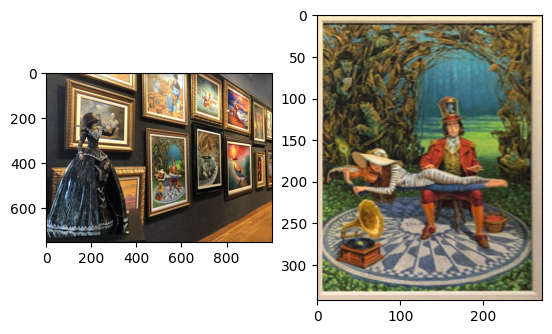

In [111]:
# show the original and new image side by side
plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(img1)
axarr[1].imshow(imwarped1)

### Image 2

In [112]:
print("Enter coordinates for the second image:\n")

# TODO: For the TA

# coordinates to try
# 784 877
# 55 871
# 436 524
# 933 522

pts2_src = get_four_coords()

# pts2_src = np.array([[784, 877], [55, 871], [436, 524], [933, 522]])

Enter coordinates for the second image:

Point 1 (x y): 784 877
Point 2 (x y): 55 871
Point 3 (x y): 436 524
Point 4 (x y): 933 522


In [113]:
# find generic destination points
x2_dist, y2_dist = point_distance(pts2_src)
pts2_dst = np.array([[0, 0], [255, 0], [255, 255], [0, 255]])

In [114]:
# compute homography matrix
H = computeH(pts2_src, pts2_dst)

In [115]:
# decided to use the cv2 option (allowed in the instructions) b/c the interpolation algo is much faster than my own
imwarped2 = opencv_warpimage(img2, H, (255, 255))

<Figure size 640x480 with 0 Axes>

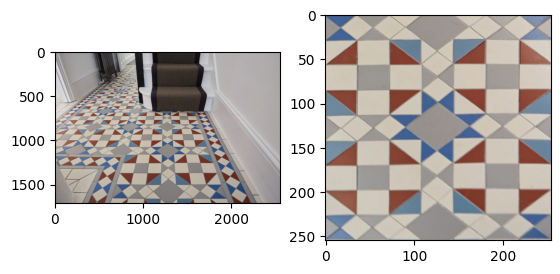

In [116]:
# display the original and warped image side by side
plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(img2)
axarr[1].imshow(imwarped2)

# Fully Automated

## Imports

In [117]:
# from scipy.ndimage import filters
from scipy.ndimage import gaussian_filter as gaussian_filter
from skimage import color
from sklearn.cluster import KMeans, DBSCAN

## Image

In [118]:
url = "https://i.redd.it/bebi64i3kbb31.jpg"

## Harris Code

In [119]:
# calculate harris reponse map based on the input image
def compute_harris_response(im,sigma=3):
  # b/c this is a harris edge detector the image must be in grayscale
  # this function will calculate a score value to each pixel in the image
  # based on how likely it is to be a corner

  # horiztontal derivative
  imx = np.zeros(im.shape)
  gaussian_filter(im, (sigma,sigma), (0,1), imx)

  # vertical derivative 
  imy = np.zeros(im.shape)
  gaussian_filter(im, (sigma,sigma), (1,0), imy)

  # compute components of the Harris matrix
  Wxx = gaussian_filter(imx*imx,sigma) # smoothed square based on horizontal deriv
  Wxy = gaussian_filter(imx*imy,sigma) # smoothed square based on horizontal & vertical deriv
  Wyy = gaussian_filter(imy*imy,sigma) # smoothed square based on vertical deriv

  # determinant and trace
  Wdet = Wxx*Wyy - Wxy**2
  Wtr = Wxx + Wyy

  # return the response
  # (ratio of the determinant to the trace of the harris matrix)
  return Wdet / Wtr


In [120]:
#
def get_harris_points(harrisim,min_dist=10,threshold=0.1):

  # find top corner candidates above a threshold
  # and then apply
  corner_threshold = harrisim.max() * threshold
  harrisim_t = (harrisim > corner_threshold) * 1 # *1 converts this to a bin map

  # b/c this is a bin map, candidates will be 1, 
  # non canidates with be 0

  # get coordinates of potential corners
  coords = np.array(harrisim_t.nonzero()).T

  # get the values for each of the potential corners
  candidate_values = [harrisim[c[0],c[1]] for c in coords]

  # sort corners in decending order
  index = np.argsort(candidate_values)

  # store allowed point locations in array
  allowed_locations = np.zeros(harrisim.shape) # create a zero matrix
  allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1 # reduces multiple detections
  # note this is a binmap as well, as the matrix was init to zero, and 1's were filled

  # select the best points taking min_distance into account
  filtered_coords = []
  for i in index:
    if allowed_locations[coords[i,0],coords[i,1]] == 1: # is in an allowed locatiuon
      filtered_coords.append(coords[i]) # append coord
      allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+min_dist), # update to exlude the location
                        (coords[i,1]-min_dist):(coords[i,1]+min_dist)] = 0

  return filtered_coords


In [121]:
def get_distance (p1, p2):
  # generic distance funciton
  # angle = np.arctan2(p2[1] - p1[1], p2[0] - p1[0])
  return int(np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2))

In [122]:
# plots corners found in image
def plot_harris_points(image,filtered_coords):
  plt.figure()
  plt.imshow(image, cmap='gray')

  # show where the candidate corners are
  plt.plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'*', color='yellow')
  
  plt.axis('off')
  plt.show()

In [123]:
def plot_image_with_centroids(image, centroids):
    # plots corners found in image and centroids
    plt.figure()
    plt.imshow(image, cmap='gray')

    # p[0] and p[1] flipped, that's the only difference from above
    plt.plot([p[0] for p in centroids],[p[1] for p in centroids],'*', color='yellow')
    
    plt.axis('off')
    plt.show()

## Harris Test

In [124]:
img_color = io.imread(url) # coloredd image, for final result
img = color.rgb2gray(io.imread(url)) # gray image for use w/ Harris

In [125]:
# use the two functions above to generate corner responses from the harris algorithm
harrisim = compute_harris_response(img, sigma=12)
filtered_coords = get_harris_points(harrisim,min_dist=5,threshold=0.3)

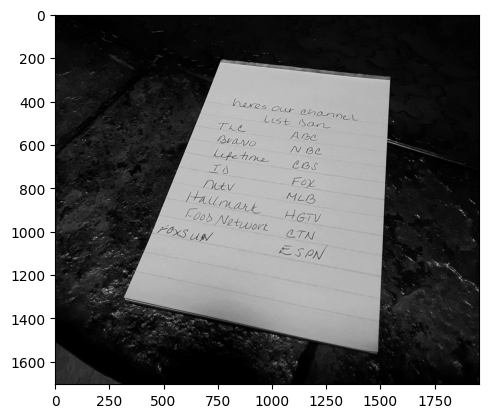

In [126]:
plt.imshow(img, cmap='gray')

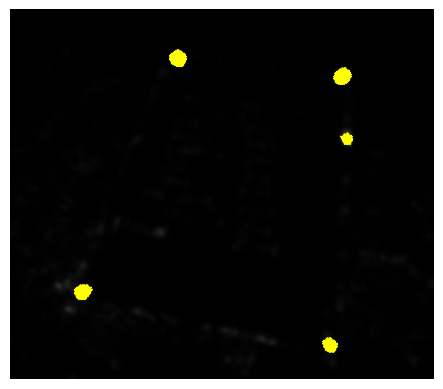

In [127]:
# here is a test with the points and the new manipulated image
plot_harris_points(harrisim, filtered_coords)

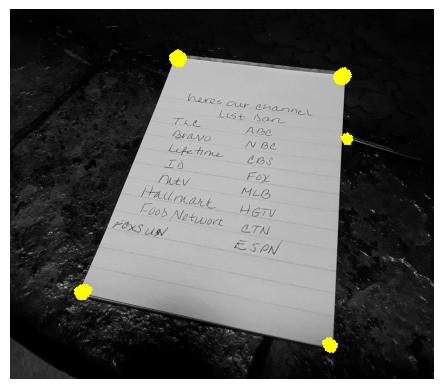

In [128]:
# here we show the points applied ot the original image
plot_harris_points(img, filtered_coords)

In [129]:
# all x and y points
y = [p[0] for p in filtered_coords]
x = [p[1] for p in filtered_coords]

In [130]:
# convert x adn y lists into an np array w/ all values as pairs (x,y)
coords_array = np.empty((0, 2), dtype=int)
for i in range(len(x)):
    row = np.array([int(x[i]), int(y[i])], dtype=int)
    coords_array = np.vstack([coords_array, row])

In [131]:
# checking to see how many points there are
# currently there are 191, but we only need 4!
len(coords_array)

191

## Grouping

In [132]:
# use kmeans to limit the coords down to averages
# THIS IS NOT USED
_coords_array = np.column_stack((x, y))
_kmeans = KMeans(n_clusters=4)
_labels = _kmeans.fit_predict(coords_array)
_centroids = _kmeans.cluster_centers_.astype(int)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


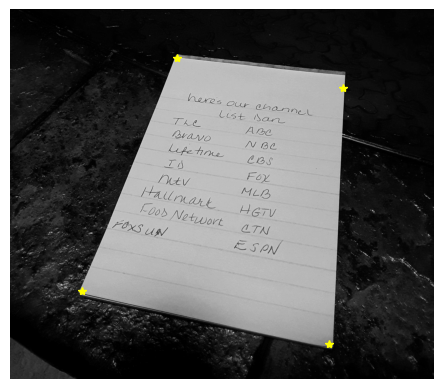

In [133]:
'''
as we can see, this image has a low hanging coordinate at
the top right corner

i could not solve this issue with kmeans alone as there was a total of 5 detected
corners

as a result, this was not used in the final version
'''
plot_image_with_centroids(img, _centroids)

In [134]:
'''

DBSCAN was used instead of kmeans
this is because there was an extra point cluster that 
was effecting my points final poisition
DBSCAN groups together points that are close to each other in a 
high-dimensional space, removing this issue altogether 

'''

def dbscan (coords, eps=10, min_samples=5):
  dbscan = DBSCAN(eps=eps, min_samples=min_samples)

  labels = dbscan.fit_predict(coords)

  n_clusters = 4

  centroids = []
  for i in range(n_clusters):
      mask = labels == i
      cluster_coords = coords[mask]
      centroid = np.mean(cluster_coords, axis=0)
      centroids.append(centroid.astype(int))

  return np.array(centroids)

In [135]:
# as we can see in the image, the coordinate shift on the top right corner is 
# no longer an issue
centroids = dbscan(coords_array)

# notice that there are only 4 coords now
len(centroids)

4

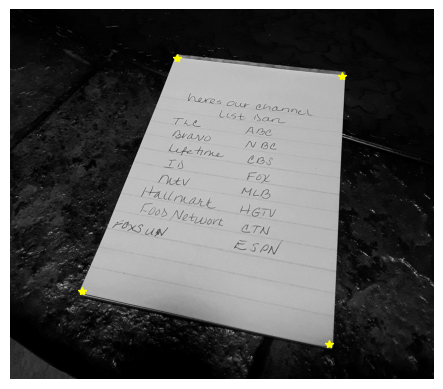

In [136]:
# showing the 4 coords after DBSCAN algo
# notice that they are pretty close to the corners and 
# appear to be useful later on
plot_image_with_centroids(img, centroids)

## Final 

In [137]:
def sort_coords(centroids):
  # lexical sort on the finaly 4 coordinates, and order them in a clockwise pattern
  # starting from the bottom left
  sorted_indices = np.lexsort((centroids[:, 1], -centroids[:, 0]))
  order = [2,0,1,3] 
  return centroids[sorted_indices][order]

  # this was done so that the image warping should be dynamic, later this will be
  # tested to see if my solution works on multiple images, rather than just this one

In [138]:
# check points
sorted_centroids = sort_coords(centroids)
sorted_centroids

array([[ 771,  223],
       [1530,  305],
       [1472, 1544],
       [ 332, 1299]])

In [139]:
def get_xy_dist(coords):
  x_dist = get_distance(coords[3], coords[2])
  y_dist = get_distance(coords[0], coords[2])

  return x_dist,y_dist

In [140]:
# calculate a rough idea of how large the final image will be
x_dist, y_dist = get_xy_dist(sorted_centroids)
print(f'{x_dist}\n{y_dist}\n')

1166
1495



In [141]:
def get_pts_dst(x_dist, y_dist):
  return np.array([[0, 0], [x_dist, 0], [x_dist, y_dist], [0, y_dist]])

<Figure size 640x480 with 0 Axes>

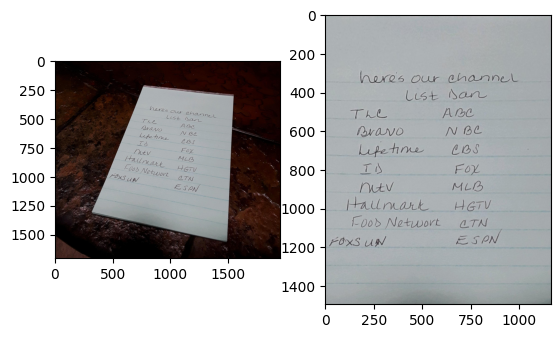

In [142]:
# get the destination points based off of the distances calculated previously
pts_dst = get_pts_dst(x_dist, y_dist)

# compute the homography matrix
H = computeH(sorted_centroids, pts_dst)

# warp the image using the colored image, homography matrix, and the approx size of the final image
imwarped = opencv_warpimage(img_color, H, (x_dist,y_dist)) # again, used opencv b/c the image interpolation is so much faster

# display the original and new image
plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(img_color)
axarr[1].imshow(imwarped)

## Wrapping up...

In [143]:
# combining all previous steps into a single function
def HarrisHomography(img, sigma=12, min_dist=5, threshold=0.3):

  # get harris values
  harrisim = compute_harris_response(img, sigma=sigma)
  filtered_coords = get_harris_points(harrisim,min_dist=min_dist,threshold=threshold) 

  # all x and y points from filtered coords
  y = [p[0] for p in filtered_coords]
  x = [p[1] for p in filtered_coords]

  # convert x adn y lists into an np array w/ all values as pairs (x,y)
  coords_array = np.empty((0, 2), dtype=int)
  for i in range(len(x)):
    row = np.array([int(x[i]), int(y[i])], dtype=int)
    coords_array = np.vstack([coords_array, row])

  # get the 4 centroids
  centroids = dbscan(coords_array)

  # sort the centroids
  sorted_centroids = sort_coords(centroids)

  # get the x,y distances
  x_dist, y_dist = get_xy_dist(sorted_centroids)

  # get destination points
  pts_dst = get_pts_dst(x_dist, y_dist)

  # compute the homography matrix and return
  return computeH(sorted_centroids, pts_dst), (x_dist, y_dist)


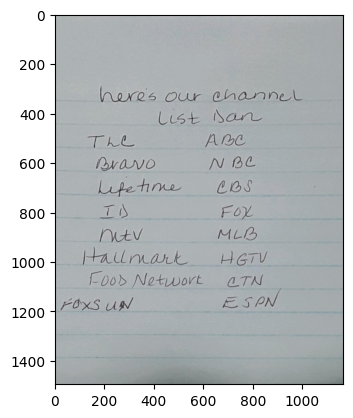

In [144]:
# the three calls that can be made to generate a new image using all of the defined functions
H,(x_dst,y_dst) = HarrisHomography(color.rgb2gray(img_color))
imwarped = opencv_warpimage(img_color, H, (x_dst,y_dst))
plt.imshow(imwarped)

# Final Notes

I did some additional testing, using the function above, and I couldn't get a lot of images to work. I tried various pictures of house windows, all of which failed. I then attempted to break it down step by step and found that it had a hard time finding the correct corners. A lot of background portions of windows were being noticed more heavily than the actual corners around the window. However, paper (wrinkled or not) seemed to work fine. I think my Harris corner detector is really only suited for images where there are 4 prominant corners and very little going on in the background. I will note that min_dist seemed to have a large effect on reducing the amount of corners being displayed. 

As you've probably gathered, I have created a Harris corner detector using pieces of code from previous homework and following the assigned textbook the professor has listed in the syllabus. I've also included various other helper functions to help me generate the 4 corners needed to complete the project. One being DBSCAN. I found that this grouping algorithm worked the best, out of the few I tried. I initially tried KMeans since it was something we covered in class, but KMeans uses the entire set of points. DBSCAN on the otherhand will first reduce the amount of points based off of parameters (distance in our case) and then spit out the appropriate coordinates. This not only cuts it down to the 4 I needed but reduces the similar neighboring points down to a single point which is what I intended to do with Kmeans. 

To make the Harris corner detector I followed along with the prescribed book the professor included in the syllabus, that being Programming Computer Vision
with Python by Jan Erik Solem. The textbook definnitely helped me understand Harris corner dedtector a lot more than I did originally. However, the notes were a little lackluster. As a result, to fully comprehend what I was doing, I tried my best to break down each segment and write descriptive comments that I could come back to and analyze. 

Finally, I used a the computeH and imageWarp functions from the previous homework. However, my imageWarp function seemed to only work best with square images AND required an additional interpolation function. The interpolation function I built in the last homework is very very slow. As a result, I figured I would just use the opencv variant of warpPerspective since it was noted in the project guidelines that this was allowed. 

Moreover, I think a better approach to detecting corners would be to try different filtering techniques. Currently, I am only using gaussian filters, but including sobel edge detection earlier on may lead to better results, since the edges will be more prominant. From there I could theoretically find a way to reduce the amount of edges being shown and perhaps even train a machine learning modeel to do this dynamically. I do not have enough time to do all of this though but it would be neat to see implimented. Regardless, I think the best approach would be to first try sobel filtering, then harris corner detection. Sobel filtering can be used as a preprocessing step to estimate the image gradients before applying the Harris corner detector. By using Sobel filtering, you can obtain a more accurate estimate of the image gradients, which can improve the performance of the Harris corner detector. If that doesn't work I would try different corner detection algorithms such as Shi-Tomasi. Or, I could impliment a local instance of this program with the ability to slide adjust threshold, min distnace, sigma values so that it's easier to adjust. Since each image requires different values it would make sense that this would have to be finetuned for each image. The reason sigma is important is because Harris corner detection is scale sensitive. Additionally, I think my non-maximum suppresion technique could be improved. 

In conclusion, I imported and adjusted my original computeH and imageWarp functions from the previous homework. Followed the book to impliment a Harris corner detector. Tested different values to make it work properly. Then used the points generated from the Harris algorithm in my computeH function to generate a homography matrix that could be applied to an image. I used the help of opencv to apply this matrix to the original image (with color) and analyzed the results.